In [1]:
%matplotlib inline

import rasterio
import rasterio.warp
import rasterio.transform
from rasterio.plot import show

In [2]:
DATA_DIR = "/Users/Tim/dev/python/DeepWater/data"

In [3]:
dataset = rasterio.open(DATA_DIR + 
                        "/input/Sentinel-2/S2A_OPER_MSI_L1C_TL_SGS__20160908T110617_20160908T161324_A006340_T31UFU_N02_04_01.tif")

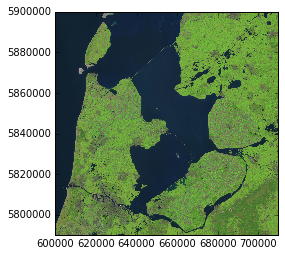

In [4]:
show(dataset)

In [4]:
print(dataset.crs)

CRS({'init': u'epsg:32631'})
epsg:32631


In [9]:
def get_bounds(raster_dataset):
    left, bottom, right, top = raster_dataset.bounds
    src_crs = raster_dataset.crs
    dst_crs = "EPSG:4326"
    left, bottom, right, top = rasterio.warp.transform_bounds(
        src_crs, dst_crs, *raster_dataset.bounds)
    return left, bottom, right, top

print(get_bounds(dataset))

(4.464980367154928, 52.2225660330366, 6.141769904458253, 53.24020834897157)


In [7]:
def lat_lon_to_pixel(point, raster_dataset):
    lat, lon = point
    src_crs = "EPSG:4326"
    dst_crs = raster_dataset.crs
    xs, ys = rasterio.warp.transform(src_crs, dst_crs, [lat], [lon])
    rows, cols = rasterio.transform.rowcol(raster_dataset.transform, xs, ys)
    return (rows[0], cols[0])

def pixel_to_lat_lon(pixel, raster_dataset):
    x, y = raster_dataset.transform * pixel
    # Coordinate reference system of the GeoTIFF.
    src_crs = raster_dataset.crs
    # Destination coordinate reference system. We want to get the longitude
    # and latitude so we use EPSG:4326 also known as WGS 84.
    dst_crs = "EPSG:4326"
    lats, lons = rasterio.warp.transform(src_crs, dst_crs, [x], [y])
    return (lats[0], lons[0])

print(lat_lon_to_pixel(pixel_to_lat_lon((0,0), dataset), dataset))

(0, 0)


In [4]:
import fiona
import pprint

In [5]:
water_shapefile = "/input/Shapefiles/netherlands-latest-free/gis.osm_water_a_free_1.shp"
with fiona.open(DATA_DIR + water_shapefile) as shapefile:
    pprint.pprint(shapefile[0])
    features = [feature['geometry'] for feature in shapefile]

{'geometry': {'coordinates': [[(5.5452785, 51.4557309),
                               (5.545328, 51.456038),
                               (5.5455379, 51.4562582),
                               (5.5458916, 51.4564087),
                               (5.5463554, 51.4564559),
                               (5.5469739, 51.4564517),
                               (5.5476489, 51.4563697),
                               (5.5483078, 51.4562987),
                               (5.548689, 51.4562372),
                               (5.5490392, 51.4560413),
                               (5.5495042, 51.4557633),
                               (5.5496821, 51.4554128),
                               (5.5498582, 51.4552985),
                               (5.5502748, 51.4554282),
                               (5.5509298, 51.4549658),
                               (5.5502216, 51.4547011),
                               (5.5495297, 51.4543012),
                               (5.5486859, 51.45411

In [8]:
def transfrom_coordinates(geometries, dataset):
    for i, feature in enumerate(geometries):
        if i % 1000 == 0:
            print i
        if feature['type'] == 'Polygon':
            for j, points in enumerate(feature['coordinates']):
                transformed_points = map(lambda (lon, lat): lat_lon_to_pixel((lat, lon), dataset), points)
                geometries[i]['coordinates'][j] = transformed_points
        else:
            # TODO: Implement
            pass
    return geometries

features = transfrom_coordinates(features[:10000], dataset)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [10]:
import rasterio.features

image = rasterio.features.rasterize(((g, 255) for g in features), 
                                    out_shape=dataset.shape, 
                                    transform=dataset.transform)

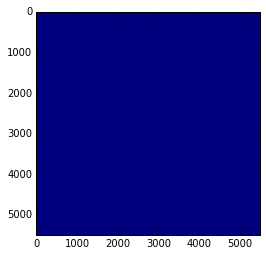

In [11]:
show(image)

In [2]:
import numpy as np

def image_from_tiles(tiles, tile_size, image_shape):
    image = np.zeros(image_shape)

    for tile, (row, col) in tiles:
        image[row:row + tile_size, col:col + tile_size, :] = tile

    return image

tile1 = np.array([[[1],[0]],[[0],[1]]])
tile2 = np.array([[[1],[1]],[[0],[0]]])
tile3 = np.array([[[0],[1]],[[1],[0]]])
tile4 = np.array([[[0],[1]],[[0],[1]]])

tiles = [(tile1, (0,0)), (tile2, (0,2)), (tile1, (2,0)), (tile2, (2,2))]
print(image_from_tiles(tiles, 2, (4,4,1)))

[[[ 1.]
  [ 0.]
  [ 1.]
  [ 1.]]

 [[ 0.]
  [ 1.]
  [ 0.]
  [ 0.]]

 [[ 1.]
  [ 0.]
  [ 1.]
  [ 1.]]

 [[ 0.]
  [ 1.]
  [ 0.]
  [ 0.]]]
